In [1]:
!pip install torchsummary

Соревнование на kaggle от Google 

Задача заключается в сегментировании инверсионных следов.

Инверсионные следы - это облака кристалликов льда, которые образуются в выхлопных газах авиационных двигателей. 

![Alt text](https://storage.googleapis.com/kaggle-media/competitions/Google-Contrails/waterdroplets.png)

# **Загрузка библиотек основа на PyTorch**
**Сама модель и обучение будет написано на PyTorch но для выгрузки данных и обработки могут понадобится PIL или OpenCV**

In [2]:
import os
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython import display
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import transforms
from tqdm.notebook import tqdm
from torchsummary import summary
from PIL import Image

**Прописываем класс датасета для загрузки в даталодер**

Для PyTorch Dataset должен выдавать данные по индексу и показывать всю длинну Dataset'а, а далее этот Dataset необходимо загрузить в Dataloader с его парамметрами 

In [3]:
class DatasetGR(Dataset):
    def __init__(self, data_path, size_image, is_train=True):
        self.data_path = data_path
        self.file_list = [entry.name for entry in os.scandir(self.data_path) if entry.is_dir()]
        self.is_train = is_train
        self.image_size = size_image
    
    def normalize_range(self, data, bounds):
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def preprocess_data(self, data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        N_TIMES_BEFORE = 4
        
        tdiff = self.normalize_range(data["band_15"] - data["band_14"], _TDIFF_BOUNDS)
        cloud_top = self.normalize_range(data["band_14"] - data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        t11 = self.normalize_range(data["band_14"], _T11_BOUNDS)
        
        false_color = np.clip(np.stack([tdiff, cloud_top, t11], axis=2), 0, 1)
        img = false_color[..., N_TIMES_BEFORE]
        
        return img
    
    def load_data(self, folder_path):
        data = {}
        for band_name in ["band_11", "band_14", "band_15"]:
            band_data = np.load(os.path.join(folder_path, f"{band_name}.npy"))
            data[band_name] = band_data
        return data
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        folder_path = os.path.join(self.data_path, self.file_list[idx])
        data = self.load_data(folder_path)
        
        img = self.preprocess_data(data)
        
        img = torch.tensor(img).float()
        
        img = img.permute(2, 0, 1)
        
        if self.is_train:
            mask = np.load(os.path.join(folder_path, 'human_pixel_masks.npy'))
            
            mask = torch.tensor(mask).float()
            mask = mask.permute(2, 0, 1)
            return img, mask
        
        return img

Описываем даталоадеры для train и val выборки

In [4]:
train_dataset = DatasetGR('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train', 256, True)
train_dataloader = DataLoader(train_dataset, 16, shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=2)
val_dataset = DatasetGR('/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation', 256, True)
val_dataloader = DataLoader(val_dataset, 16, num_workers=2, pin_memory=True, prefetch_factor=2)

Описываем на каком устройстве будет обучение преимущественно на GPU

In [5]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

**Напишем нащу модель, выбор пал на UNet так как очень хорошо описывает тонкие линии и проблемма с затуханием градиента мене выражена в таких моделях**

![Alt text](https://www.mdpi.com/applsci/applsci-08-01656/article_deploy/html/images/applsci-08-01656-g001-550.jpg)

Эта модель очень хорошо подходит для задачи сегментации,я использовал двойные свёрточные слои с ButchNorm(для нормализации) эта модель будет более быстро обучаться, по сравнению с ResNet так как там будет или больше параметров или слишком грубый pooling и unpooling. За счёт skip-conection слоёв наша модель будет обрабатывать и лучше востанавливать мелкие линии (как и  в Biomedical Image Segmentation in 2015)

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, mid_chanels, out_channels):
        super().__init__()
        
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_chanels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_chanels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_chanels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_classes):
        super().__init__()
        self.in_channels = in_channels
        self.out_classes = out_classes
        self.down_0 = DoubleConv(self.in_channels, 64)
        self.pool_0 = nn.MaxPool2d(2, 2, return_indices=True) # 256 -> 128
        self.down_1 = DoubleConv(64, 128)
        self.pool_1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.down_2 = DoubleConv(128, 256)
        self.pool_2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.down_3 = DoubleConv(256, 512)
        self.pool_3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16
        
        self.botelneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.unpool_3 = nn.MaxUnpool2d(2, 2) #16 -> 32
        self.up_3 = UpSample(1024, 512, 256)
        self.unpool_2 = nn.MaxUnpool2d(2, 2) #32 -> 64
        self.up_2 = UpSample(512, 256, 128)
        self.unpool_1 = nn.MaxUnpool2d(2, 2) #64 -> 128
        self.up_1 = UpSample(256, 128, 64)
        self.unpool_0 = nn.MaxUnpool2d(2, 2) #128 -> 256
        self.up_0 = UpSample(128, 64, self.out_classes)
    def forward(self, x):
        #encoder
        x0 = self.down_0(x)
        x_after_pool_0, ind0 = self.pool_0(x0)
        x1 = self.down_1(x_after_pool_0)
        x_after_pool_1, ind1 = self.pool_1(x1)
        x2 = self.down_2(x_after_pool_1)
        x_after_pool_2, ind2 = self.pool_2(x2)
        x3 = self.down_3(x_after_pool_2)
        x_after_pool_3, ind3 = self.pool_3(x3)
        
        #botelneck
        btne = self.botelneck(x_after_pool_3)
        
        #decoder
        x = self.unpool_3(btne, ind3)
        x = self.up_3(x, x3)
        x = self.unpool_2(x, ind2)
        x  = self.up_2(x, x2)
        x = self.unpool_1(x, ind1)
        x  = self.up_1(x, x1)
        x = self.unpool_0(x, ind0)
        x = self.up_0(x, x0)
        return x
        
        
        

В функции обучения постарался добавить и scheduler который понижает learning rate спустя какое то количество шагов и сохранение лучшего варианта на валидационной выборке чтобы модель не сильно переобучалась на тренировочном наборе

In [7]:
def train(model, optimizer, scheduler, loss_F, epochs, data_tr, data_vl):
    model.to(device)
    torch.cuda.empty_cache()
    losses_train = []
    losses_val = []
    min_val_loss  = 1
    for epoch in range(epochs):
        print(f"Epoch {epoch} of {epochs}")
        model.train()
        loss_sum = 0
        for x, y in tqdm(data_tr):
            x, y = x.to(device), y.to(device)
            
            loss = loss_F(model(x), y)
            loss_sum += loss.item()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        losses_train.append(loss_sum / len(data_tr))
        print(loss_sum / len(data_tr))
        
        model.eval()
        avg_loss_val = 0
        
        with torch.no_grad():
            for x, y in tqdm(data_vl):
                x, y = x.to(device), y.to(device)
                
                pred = model(x)
                loss = loss_F(pred, y)
                avg_loss_val += loss.item()
            if avg_loss_val / len(data_vl) < min_val_loss:
                min_val_loss = avg_loss_val / len(data_vl)
                torch.save(model, 'best_val_weight.pth')
            losses_val.append(avg_loss_val / len(data_vl))
            print(avg_loss_val / len(data_vl))
        if scheduler:
            scheduler.step()
        torch.cuda.empty_cache()
    return (losses_train, losses_val)

Функцию ошибки выбрал Dice loss

In [8]:
class Dice(nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
        smooth = 1.
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )
    
dice = Dice()

Описываем модель и смотрим сколько обучающих параметров

In [9]:
model = UNet(3, 1)
summary(model.to(device), input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14    

Обучение выбор оптимизатора

In [10]:
model = UNet(3, 1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)
dice_loss = Dice()
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
#train(model, optimizer, scheduler, dice_loss, 30, train_dataloader, val_dataloader)

Для разграничения предсказания

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x+1e-8))

Загрузка и предобработка моделью и нахождение порогового значения

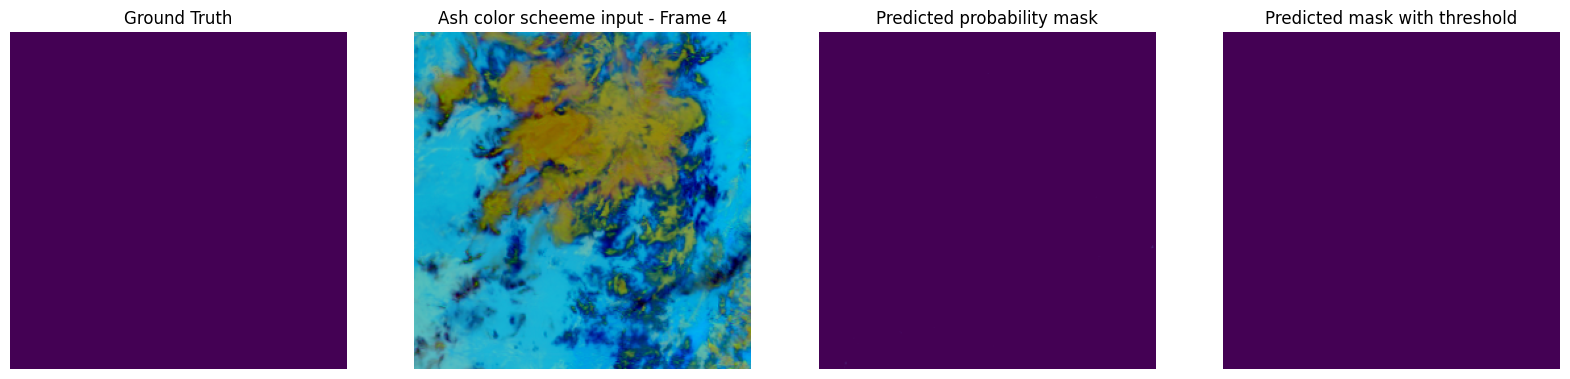

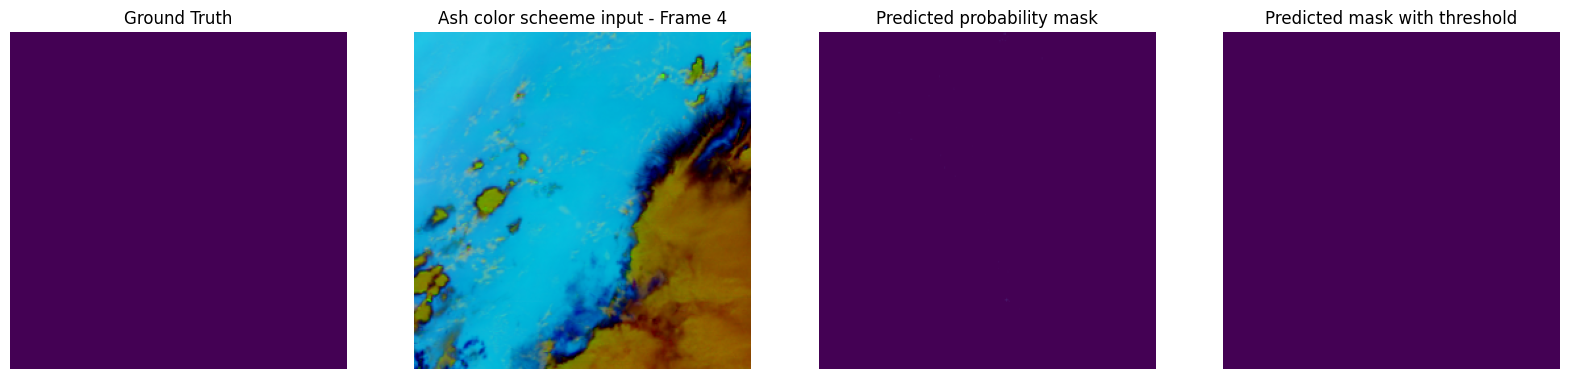

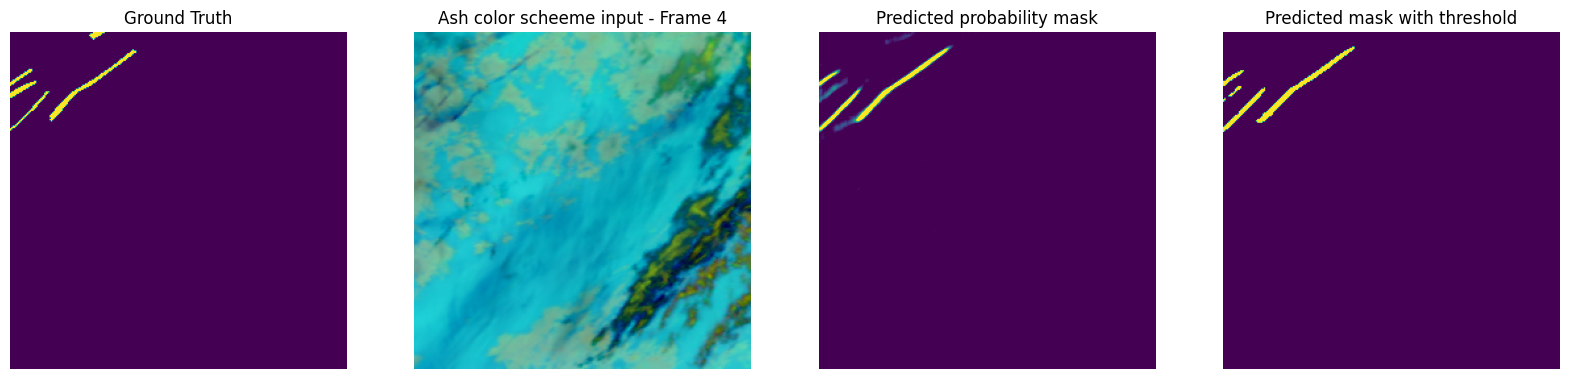

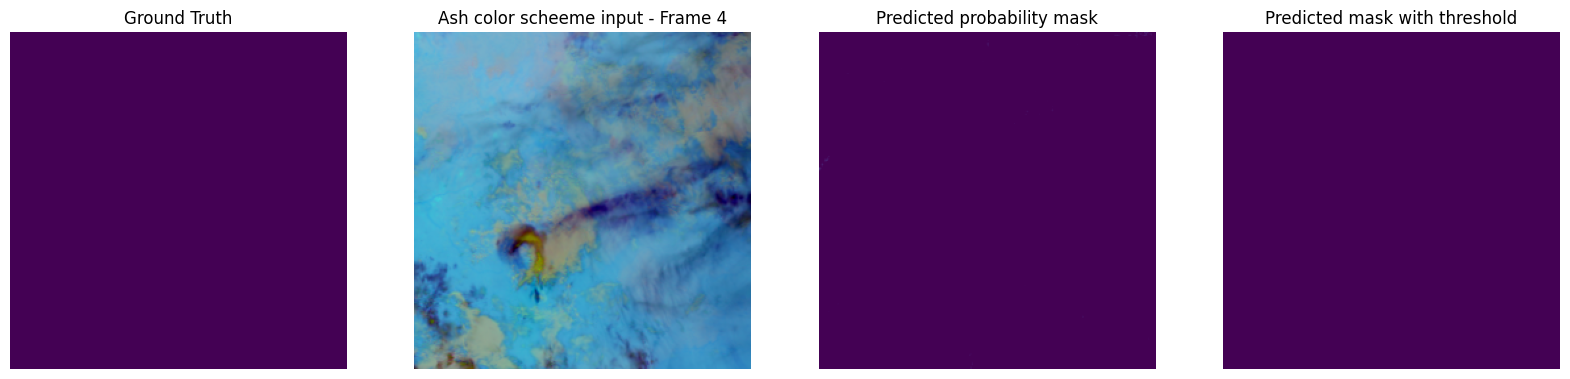

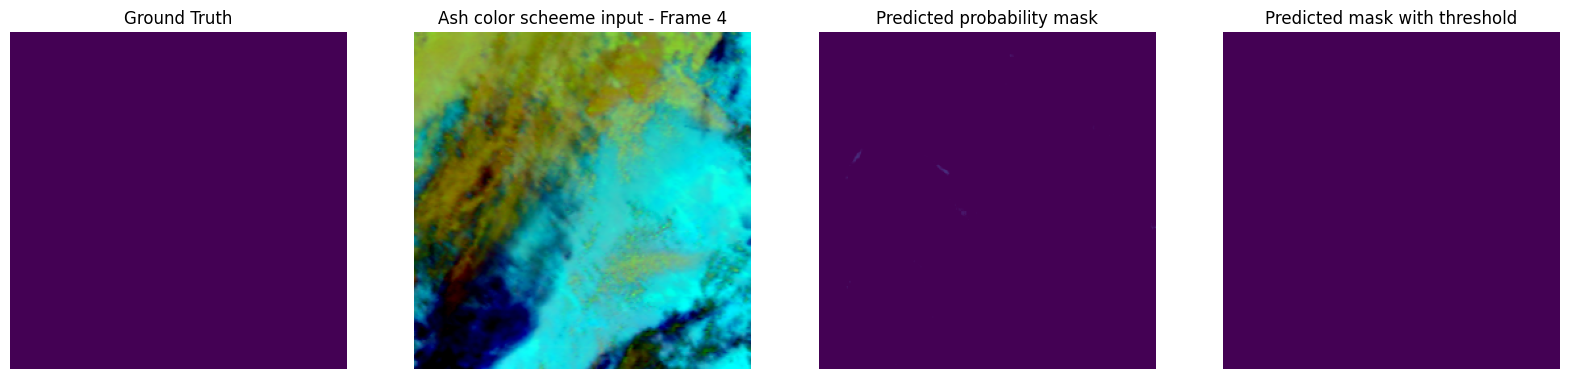

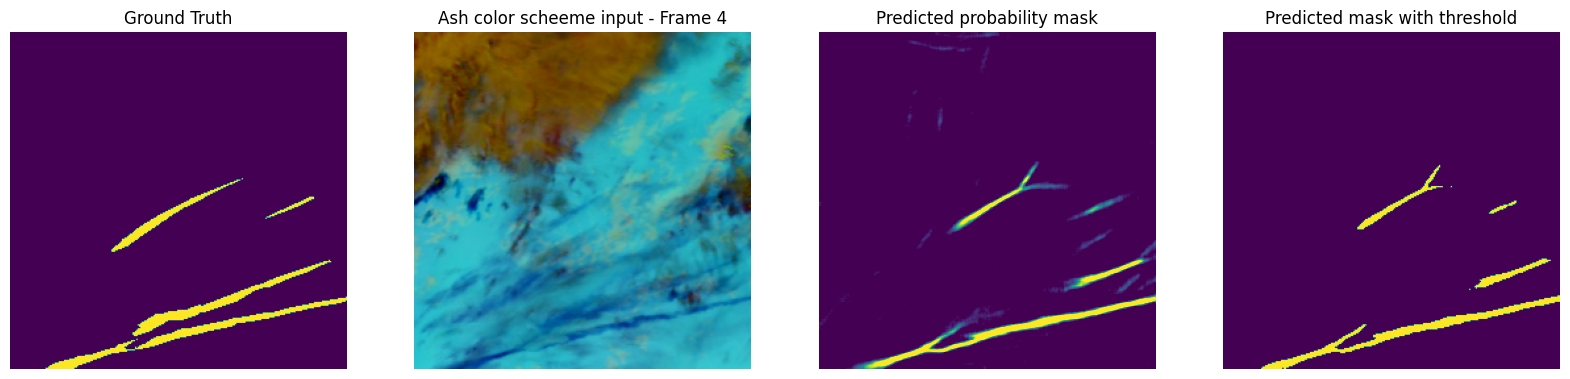

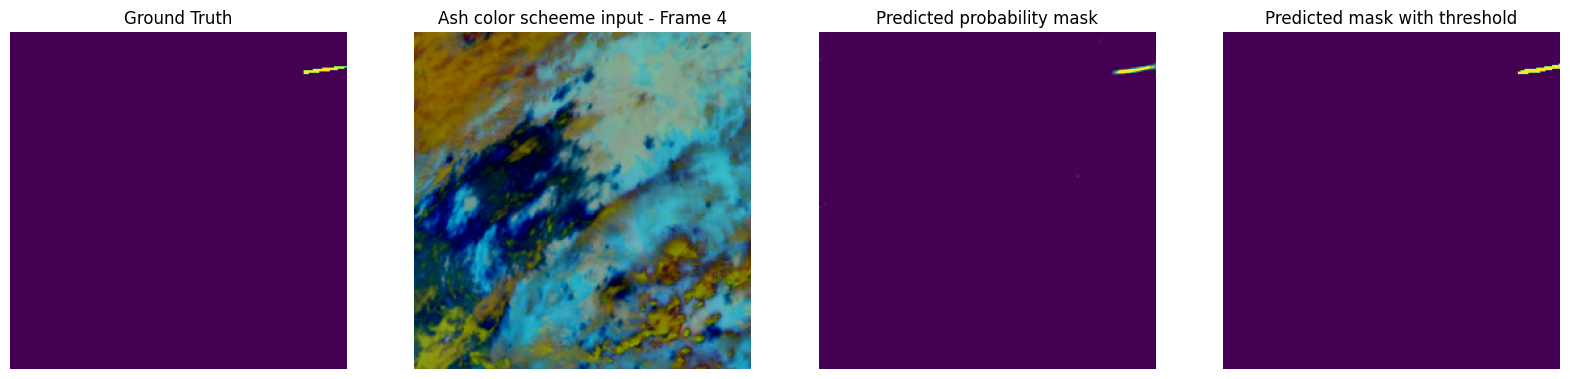

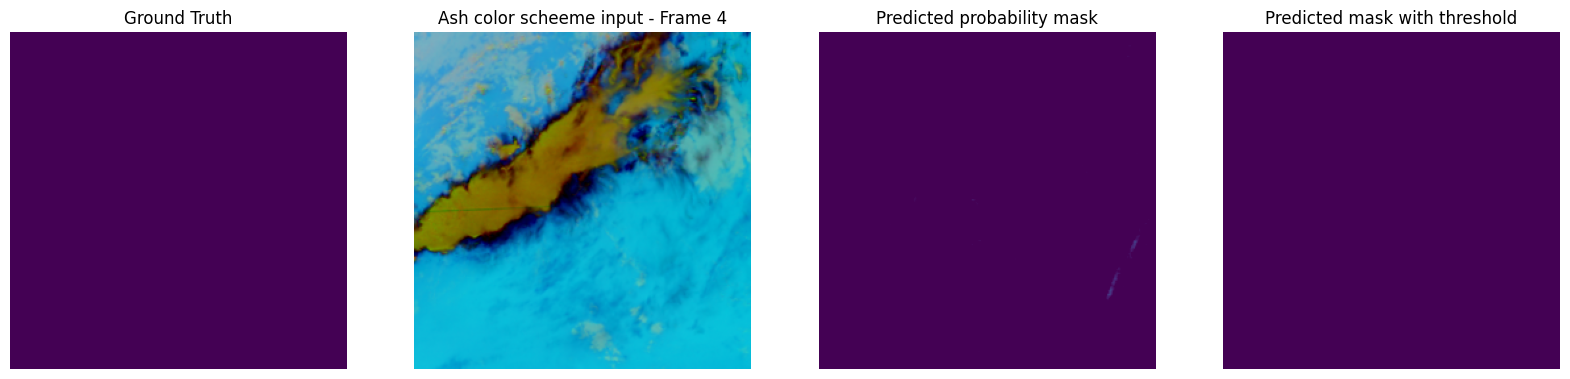

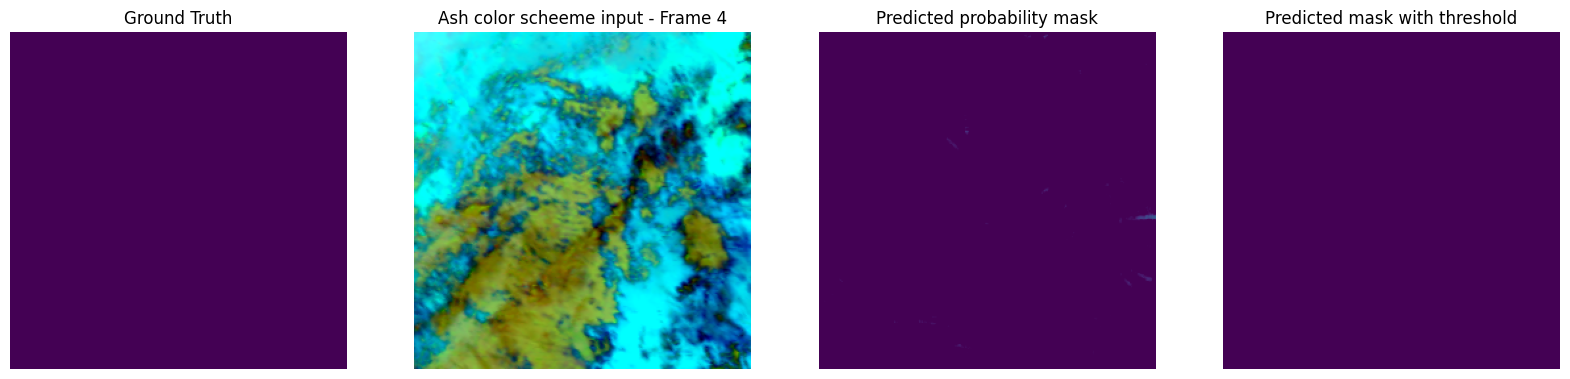

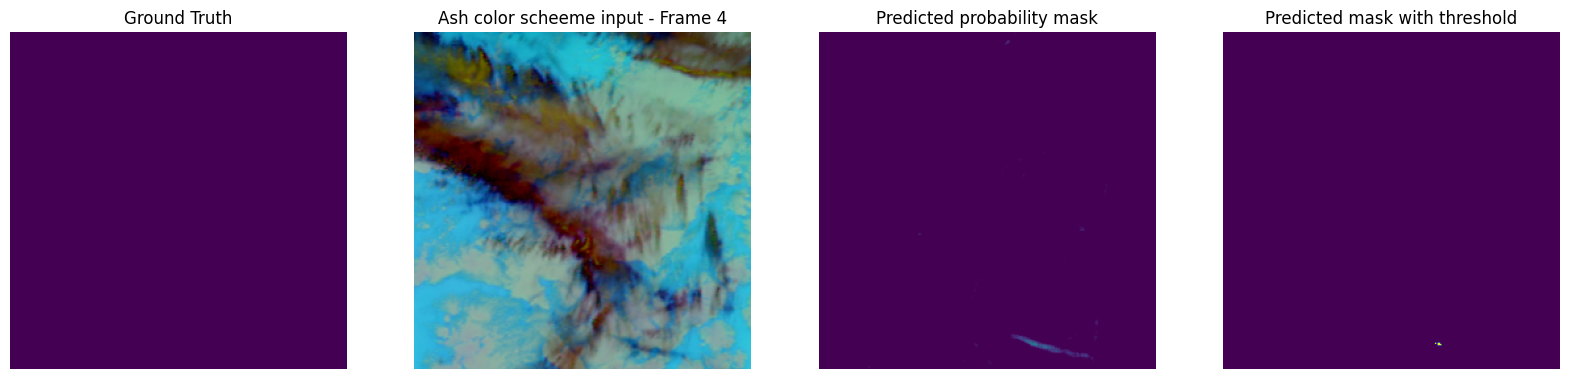

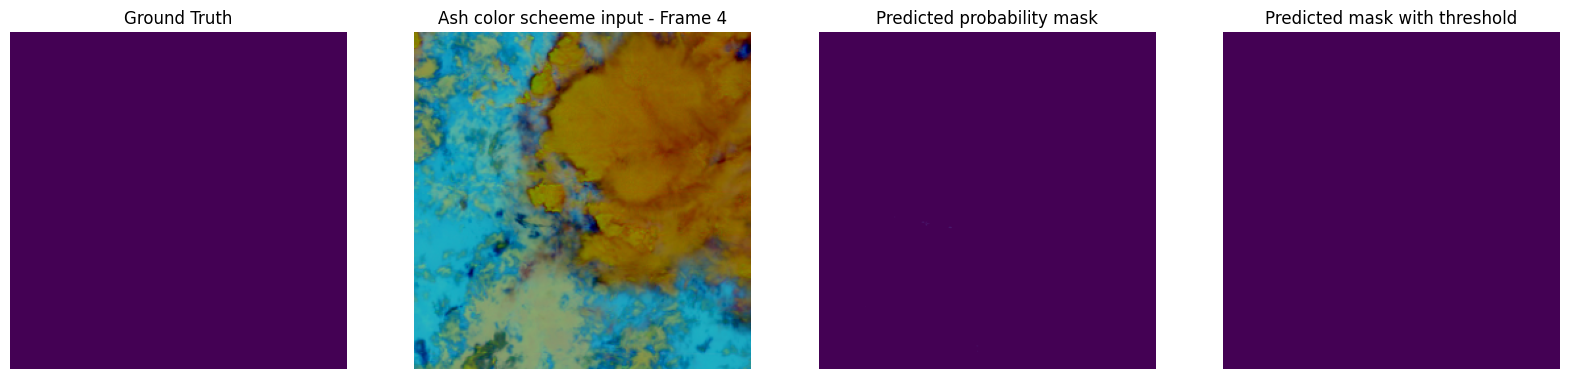

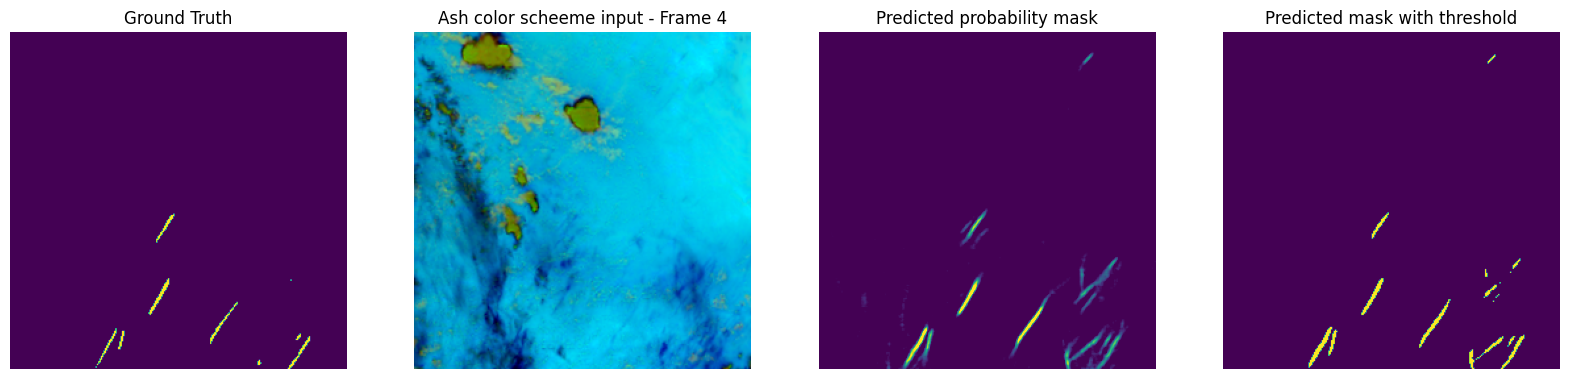

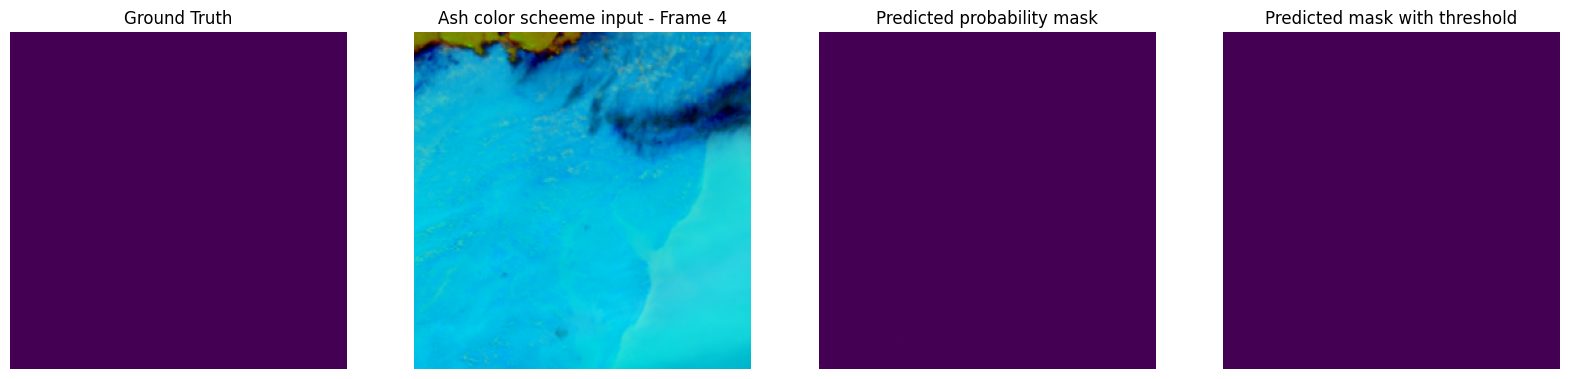

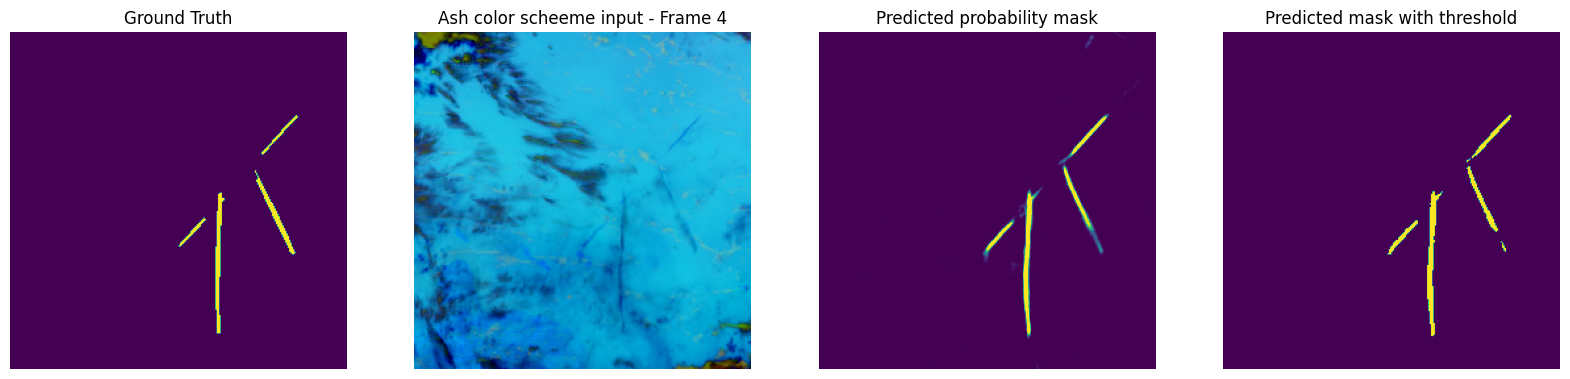

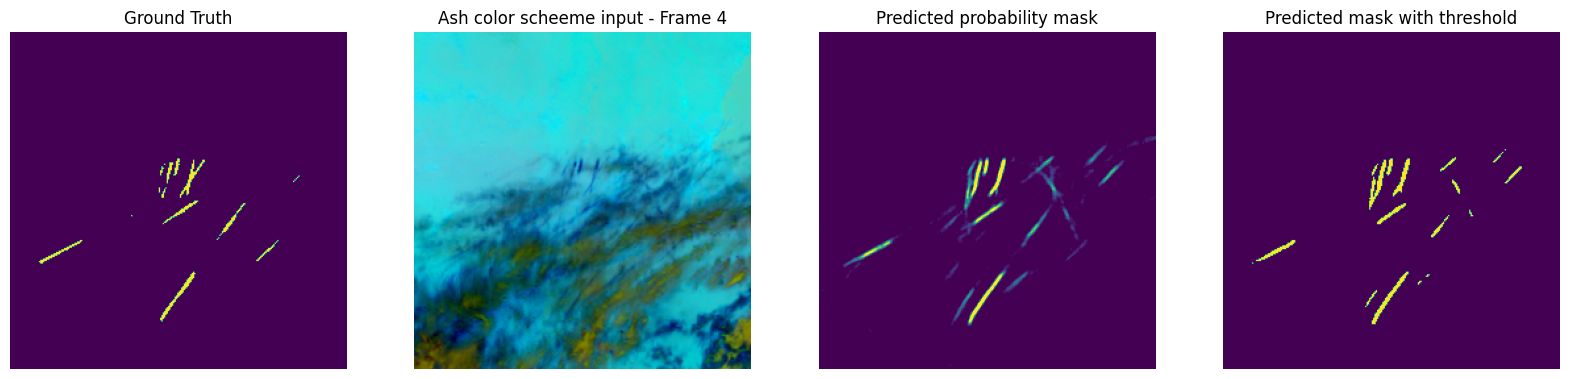

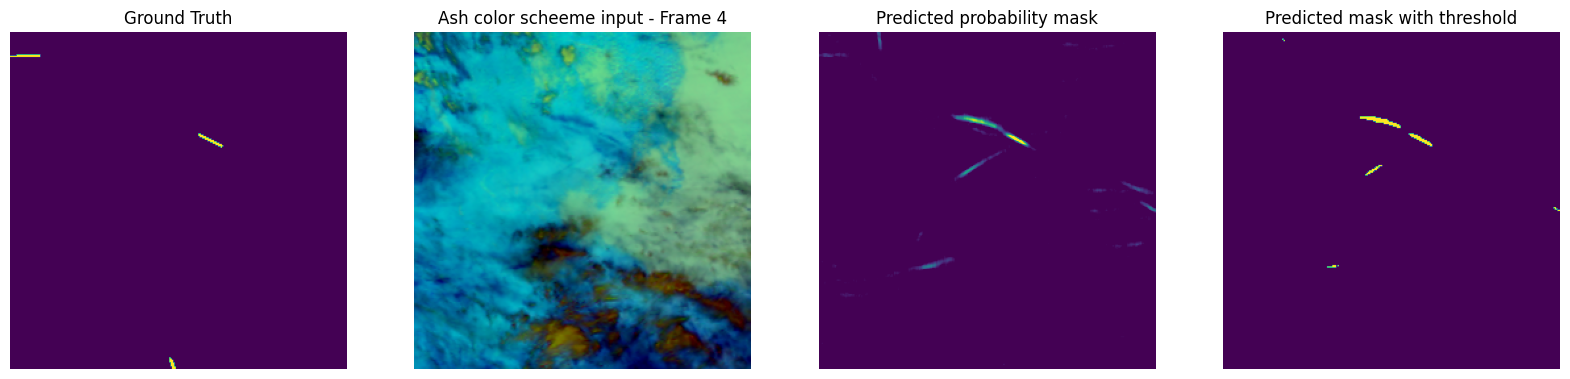

In [12]:
model = torch.load('/kaggle/input/unet-gr-model/my_model.pth')
batches_to_show = 1
model.eval()
optim_threshold = 0.58
for i, data in enumerate(train_dataloader):
    images, mask = data
    
    # Predict mask for this instance
    if torch.cuda.is_available():
        images = images.cuda()
    predicated_mask = sigmoid(model.forward(images[:, :, :, :]).cpu().detach().numpy())
    
    # Apply threshold
    predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    
    images = images.cpu()
        
    for img_num in range(0, images.shape[0]):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
        axes = axes.flatten()
        
        # Show groud trought 
        axes[0].imshow(mask[img_num, 0, :, :])
        axes[0].axis('off')
        axes[0].set_title('Ground Truth')
        
        axes[1].imshow(images[img_num, :, :, :].permute(1, 2, 0))
        axes[1].axis('off')
        axes[1].set_title('Ash color scheeme input - Frame 4')

        # Show predicted mask
        axes[2].imshow(predicated_mask[img_num, 0, :, :], vmin=0.5, vmax=0.72)
        axes[2].axis('off')
        axes[2].set_title('Predicted probability mask')

        # Show predicted mask after threshold
        axes[3].imshow(predicated_mask_with_threshold[img_num, :, :])
        axes[3].axis('off')
        axes[3].set_title('Predicted mask with threshold')
        plt.show()
    
    if i + 1 >= batches_to_show:
        break

Сохранение модели

In [13]:
torch.save(model, 'my_model_1.pth')

# Сохранение весов модели
torch.save(model.state_dict(), 'my_model_weights.pth')

In [14]:
from IPython.display import FileLink
FileLink(r'my_model_1.pth')

/kaggle/working/my_model_1.pth

Для кодировки модели для предсказания

In [15]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if mask_rle != '-': 
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

Предсказание

In [16]:
test_dataset = DatasetGR('/kaggle/input/google-research-identify-contrails-reduce-global-warming/test', 256, False)
test_dataloader = DataLoader(test_dataset, 1, shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=2)

In [17]:
import pandas as pd
submission = pd.DataFrame({'record_id': [], 'encoded_pixels': []})

In [18]:
[entry.name for entry in os.scandir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/test') if entry.is_dir()]

['1002653297254493116', '1000834164244036115']

In [19]:
for image, name in zip(test_dataloader, [entry.name for entry in os.scandir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/test') if entry.is_dir()]):
    image = image.to(device)
    
    predicated_mask = sigmoid(model.forward(image[:, :, :, :]).cpu().detach().numpy())
    
    predicated_mask_with_threshold = np.zeros((image.shape[0], 256, 256))
    
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    current_mask = predicated_mask_with_threshold[:, :, :]
    submission = pd.concat([submission, pd.DataFrame({'record_id': [name], 'encoded_pixels': [list_to_string(rle_encode(current_mask))]})], ignore_index=True)

In [20]:
submission = submission.set_index('record_id')

In [21]:
submission

encoded_pixels
record_id                                                             
1002653297254493116                                                  -
1000834164244036115  40966 2 41222 3 41479 4 41737 4 41994 5 42252 ...

In [22]:
submission.to_csv('submission.csv')